# Series temporales
Nuestra variable independiente será el tiempo que lo denotaremos por t $\to$ 
* ``si vamos al  pasado`` se expresará t-1, t-2, t-3,... 
* ``si vamos al  futuro`` se expresará t+1, t+2, t+3,... 

* Estacionaria --> 
    * ``se mantega la media`` 
    * `` sea homocedástica`` = se mantenga la varianza

In [ ]:
## Librerias
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
#from pandas_datareader import data as web
from pydataset import data
plt.style.use('ggplot')

In [ ]:
comienzo=datetime(2010,1,1)
final=datetime(2020,3,10)

In [ ]:
final-comienzo

In [ ]:
df = pd.read_csv('./Datos/Index2018.csv')

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
df.dtypes

In [ ]:
df.date=pd.to_datetime(df.date,dayfirst=True)

In [ ]:
df.dtypes

In [ ]:
df.head()

In [ ]:
df.spx.plot()

In [ ]:
df.nikkei.plot()

In [ ]:
df_fecha=df.copy()

In [ ]:
df_fecha.set_index("date",inplace=True)

In [ ]:
df_fecha.nikkei.plot()

In [ ]:
df_fecha.head()

In [ ]:
## Frecuencia diaria
df_fecha.asfreq('d')

In [ ]:
## Frecuencia último día del mes
df_fecha.asfreq('M')

In [ ]:
## Para rellenar los nulos
## usando forward fill
df_fecha.asfreq('d',method="ffill")

In [ ]:
## usando back fill
df_fecha.asfreq('d',method="bfill")

In [ ]:
## Frecuencia último día del mes laborable
df_fecha.asfreq('BM')

In [ ]:
df_fecha.asfreq('BM').isnull().sum()

In [ ]:
## Cierre de trimestre
df_fecha.asfreq('BQ')

#### Calcular tasas de variación por "Día"
* Tasa de Variación 

$\cfrac{VF-VI}{VI}=\cfrac{VF}{VI}-1$

## Ejercicio
Calcular la tasa de variación de cada una de las columnas generando una nueva columna

Sería el valor de la fila i partido el valor de la fila i-1 y despues restarlo por 1

In [ ]:
df["nikkei_lag1"]=df["nikkei"].shift(1)

In [ ]:
df_fecha["nikkei_tv"]=df_fecha["nikkei"]/df_fecha["nikkei"].shift(1) - 1

In [ ]:
df_fecha.head()

In [ ]:
def calculo_tv(df,columna):
    return df[columna]/df[columna].shift(1) - 1

In [ ]:
ciclo,tendencia=sm.tsa.filters.hpfilter(df["nikkei"])

In [ ]:
df["Tendencia_Nikkei"]=tendencia

In [ ]:
df[["nikkei","Tendencia_Nikkei"]].plot();

In [ ]:
df["nikkei_MV"]=df["nikkei"].rolling(5).mean()

In [ ]:
df[["nikkei","Tendencia_Nikkei","nikkei_MV"]].tail(20).plot();

In [ ]:
sm.tsa.seasonal_decompose(df["nikkei"].tail(60),model="additive",period=30).plot();

## machie learning
utilizabamos la función train_test_split y ``cogíamos`` una muestra aleatoria

In [ ]:
tamanyo=int(len(df)*0.7)
df_train=df.iloc[:tamanyo]
df_test=df.iloc[tamanyo:]

In [ ]:
## Estacionariedad
import statsmodels.tsa.stattools as sts

In [ ]:
sts.adfuller(df.nikkei)

$$ H_0: \text{Los datos son no estacionarios}$$
$$ H_1: \text{Los datos son estacionarios}$$


In [ ]:
print("El p valor es: {0:.2f}".format(sts.adfuller(df.nikkei)[1]))

In [ ]:
## Suavizado de datos
### Metodo de Holt-Winters

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [ ]:
cantidad=5
alpha=2/(cantidad+1)

In [ ]:
### otra manera de medias moviles
df["nikkei_5"]=df["nikkei"].ewm(alpha=alpha).mean()

In [ ]:
df.head()

In [ ]:
df[["nikkei","nikkei_5","nikkei_MV"]].tail(20).plot()

In [ ]:
df["nikkei_EXPS"]=SimpleExpSmoothing(df["nikkei"]).fit(smoothing_level=alpha).fittedvalues

In [ ]:
df[["nikkei","nikkei_5","nikkei_MV","nikkei_EXPS"]].tail(20).plot()

In [ ]:
## Doble suavizado
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
df["nikkei_EXPS"]=ExponentialSmoothing(df["nikkei"]).fit(smoothing_level=alpha).fittedvalues.shift(-1)

In [ ]:
df[["nikkei","nikkei_5","nikkei_MV","nikkei_EXPS"]].tail(20).plot()

In [ ]:
## Suavizado triple
df["nikkei_EXPS"]=ExponentialSmoothing(df["nikkei"],trend="add",seasonal="add",seasonal_periods=12).fit(smoothing_level=alpha).fittedvalues

In [ ]:
df[["nikkei","nikkei_5","nikkei_MV","nikkei_EXPS"]].tail(20).plot()

In [ ]:
modelo=ExponentialSmoothing(df["nikkei"],trend="add",seasonal="add",seasonal_periods=12).fit()

In [ ]:
prediccion_20=modelo.forecast(20)

In [ ]:
df["nikkei"].tail(10).plot()
prediccion_20.plot(label="Prediccion modelo aditivo")

## Modelo AR
### AR(1)
$$y_t=\beta_1 y_{t-1} + C + \epsilon_{t-1}$$

### AR(p)
$$y_t=\beta_1 y_{t-1} + \beta_2 y_{t-2} + \ldots+\beta_p y_{t-p} + C + \epsilon_{t-1}$$

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
modelo_ar=ARIMA(df.nikkei,order=(1,0,0))
resultado_ar=modelo_ar.fit()

In [ ]:
resultado_ar.summary()

In [ ]:
modelo_ar2=ARIMA(df.nikkei,order=(2,0,0))
resultado_ar2=modelo_ar2.fit()
resultado_ar2.summary()

## Medias moviles
### MA(1)
$$ y_t = C + \epsilon_{t-1} $$

### MA(q)
$$ y_t = C + \epsilon_{t-1} + \ldots + \epsilon_{t-q}  $$

In [ ]:
modelo_ma=ARIMA(df.nikkei,order=(0,0,1))
resultado_ma=modelo_ma.fit()
resultado_ma.summary()

In [ ]:
### ARMA(1,1)
modelo_ma=ARIMA(df.nikkei,order=(1,0,1))
resultado_ma=modelo_ma.fit()
resultado_ma.summary()

In [ ]:
resultado_ar.summary()

In [ ]:
### ARMA(2,1)
modelo_arma21=ARIMA(df.nikkei,order=(3,0,3))
resultado_arma21=modelo_arma21.fit()
resultado_arma21.summary()

In [ ]:
### ARIMA(1,1,1)
modelo_arima111=ARIMA(df.nikkei,order=(1,1,1))
resultado_arima111=modelo_arima111.fit()
resultado_arima111.summary()

### Ejercicio
* Del fichero uspopulation calcular el mejor modelo que se ajuste utilizando un modelo  ARIMA.
una vez detectado cual es el mejor modelo ARIMA que se ajuste, divida en train y test para predecir utilizado
``modelo_entrenad.predict(start=**longitud de train**,end=**Longitud de train mas longitud del test -1)``
y comparad con la métrica pertinente si es se ajusta bien o no

Ejemplo
```
x_train=df.iloc[:tamanyo]
x_test=df.iloc[tamanyo:]
modelo=ARIMA(x_train,order=(p,i,q))
prediccion=modelo.predict(start=len(x_train),end=len(x_train)+len(x_test)-1)
```

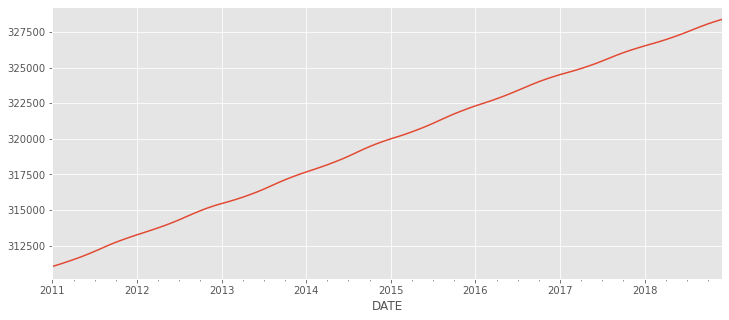

In [109]:
## Solucion
df = pd.read_csv('./Datos/uspopulation.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'


ax = df['PopEst'].plot(figsize=(12,5));
ax.autoscale(axis='x',tight=True)

In [110]:
train = df.iloc[:84]
test = df.iloc[84:]

In [119]:
model = ARIMA(df['PopEst'],order=(1,0,0))
AR1fit = model.fit()
AR1fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 PopEst   No. Observations:                   96
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -640.831
Date:                Fri, 10 Mar 2023   AIC                           1287.662
Time:                        21:05:27   BIC                           1295.355
Sample:                    01-01-2011   HQIC                          1290.772
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.198e+05   9009.890     35.497      0.000    3.02e+05    3.37e+05
ar.L1          0.9998      0.004    258.736      0.000       0.992       1.007
sigma2      3.396e+04   2.72e+04      1.247      0.212   -1.94e+04    8.73e+04
===================================================================================
Ljung-Box (L1) (Q):                   9.16   Jarque-Bera (JB):              8834.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                            -5.77
Prob(H) (two-sided):                  0.86   Kurtosis:                        48.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [120]:
model = ARIMA(df['PopEst'],order=(2,0,0))
AR1fit = model.fit()
AR1fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 PopEst   No. Observations:                   96
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -386.494
Date:                Fri, 10 Mar 2023   AIC                            780.988
Time:                        21:05:31   BIC                            791.246
Sample:                    01-01-2011   HQIC                           785.134
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.198e+05      0.006   5.26e+07      0.000     3.2e+05     3.2e+05
ar.L1          1.9964      0.007    287.984      0.000       1.983       2.010
ar.L2         -0.9967      0.007   -144.113      0.000      -1.010      -0.983
sigma2       151.9664     39.915      3.807      0.000      73.735     230.198
===================================================================================
Ljung-Box (L1) (Q):                  50.05   Jarque-Bera (JB):                 7.78
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               0.78   Skew:                            -0.25
Prob(H) (two-sided):                  0.49   Kurtosis:                         1.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.48e+19. Standard errors may be unstable.
"""

In [121]:
model = ARIMA(df['PopEst'],order=(3,0,0))
AR1fit = model.fit()
AR1fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 PopEst   No. Observations:                   96
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -350.233
Date:                Fri, 10 Mar 2023   AIC                            710.466
Time:                        21:05:36   BIC                            723.288
Sample:                    01-01-2011   HQIC                           715.649
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.198e+05      0.001   2.47e+08      0.000     3.2e+05     3.2e+05
ar.L1          2.7265      0.084     32.285      0.000       2.561       2.892
ar.L2         -2.4581      0.168    -14.625      0.000      -2.788      -2.129
ar.L3          0.7316      0.084      8.739      0.000       0.567       0.896
sigma2        69.6977     11.391      6.118      0.000      47.371      92.024
===================================================================================
Ljung-Box (L1) (Q):                   6.77   Jarque-Bera (JB):                 0.04
Prob(Q):                              0.01   Prob(JB):                         0.98
Heteroskedasticity (H):               0.67   Skew:                             0.03
Prob(H) (two-sided):                  0.27   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.19e+19. Standard errors may be unstable.
"""

In [122]:
model = ARIMA(df['PopEst'],order=(4,0,0))
AR1fit = model.fit()
AR1fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 PopEst   No. Observations:                   96
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -343.194
Date:                Fri, 10 Mar 2023   AIC                            698.387
Time:                        21:05:45   BIC                            713.774
Sample:                    01-01-2011   HQIC                           704.607
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.198e+05      0.001    5.2e+08      0.000     3.2e+05     3.2e+05
ar.L1          2.9995      0.123     24.350      0.000       2.758       3.241
ar.L2         -3.3768      0.344     -9.823      0.000      -4.051      -2.703
ar.L3          1.7514      0.332      5.268      0.000       1.100       2.403
ar.L4         -0.3742      0.112     -3.334      0.001      -0.594      -0.154
sigma2        59.7466      9.987      5.982      0.000      40.172      79.321
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                 0.34
Prob(Q):                              0.55   Prob(JB):                         0.85
Heteroskedasticity (H):               0.61   Skew:                             0.04
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.46e+20. Standard errors may be unstable.
"""

In [123]:
model = ARIMA(df['PopEst'],order=(5,0,0))
AR1fit = model.fit()
AR1fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 PopEst   No. Observations:                   96
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -341.862
Date:                Fri, 10 Mar 2023   AIC                            697.724
Time:                        21:05:50   BIC                            715.674
Sample:                    01-01-2011   HQIC                           704.979
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.198e+05      0.000   7.12e+08      0.000     3.2e+05     3.2e+05
ar.L1          2.9355      0.126     23.339      0.000       2.689       3.182
ar.L2         -3.0791      0.398     -7.735      0.000      -3.859      -2.299
ar.L3          1.1813      0.545      2.167      0.030       0.113       2.250
ar.L4          0.1296      0.406      0.319      0.750      -0.667       0.926
ar.L5         -0.1674      0.129     -1.297      0.195      -0.420       0.086
sigma2        58.0145      9.781      5.931      0.000      38.844      77.185
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):                 0.49
Prob(Q):                              0.41   Prob(JB):                         0.78
Heteroskedasticity (H):               0.61   Skew:                             0.07
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.19e+20. Standard errors may be unstable.
"""

In [124]:
model = ARIMA(df['PopEst'],order=(6,0,0))
AR1fit = model.fit()
AR1fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 PopEst   No. Observations:                   96
Model:                 ARIMA(6, 0, 0)   Log Likelihood                -326.488
Date:                Fri, 10 Mar 2023   AIC                            668.975
Time:                        21:06:03   BIC                            689.490
Sample:                    01-01-2011   HQIC                           677.268
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.198e+05      0.001   2.88e+08      0.000     3.2e+05     3.2e+05
ar.L1          2.8407      0.102     27.728      0.000       2.640       3.042
ar.L2         -3.0169      0.326     -9.257      0.000      -3.656      -2.378
ar.L3          1.8606      0.461      4.036      0.000       0.957       2.764
ar.L4         -1.5691      0.447     -3.513      0.000      -2.444      -0.694
ar.L5          1.4192      0.305      4.650      0.000       0.821       2.018
ar.L6         -0.5347      0.096     -5.545      0.000      -0.724      -0.346
sigma2        41.6400      6.883      6.050      0.000      28.150      55.130
===================================================================================
Ljung-Box (L1) (Q):                   1.90   Jarque-Bera (JB):                 1.75
Prob(Q):                              0.17   Prob(JB):                         0.42
Heteroskedasticity (H):               0.42   Skew:                             0.29
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.07e+19. Standard errors may be unstable.
"""

In [125]:
model = ARIMA(df['PopEst'],order=(12,0,0))
AR1fit = model.fit()
AR1fit.summary()

c:\Users\Daniel Montes\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 PopEst   No. Observations:                   96
Model:                ARIMA(12, 0, 0)   Log Likelihood                -292.814
Date:                Fri, 10 Mar 2023   AIC                            613.628
Time:                        21:06:18   BIC                            649.529
Sample:                    01-01-2011   HQIC                           628.140
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.198e+05      0.002   1.87e+08      0.000     3.2e+05     3.2e+05
ar.L1          2.3120      0.104     22.147      0.000       2.107       2.517
ar.L2         -2.1518      0.280     -7.691      0.000      -2.700      -1.603
ar.L3          1.5366      0.360      4.263      0.000       0.830       2.243
ar.L4         -1.4304      0.375     -3.813      0.000      -2.166      -0.695
ar.L5          1.2570      0.382      3.288      0.001       0.508       2.006
ar.L6         -1.0793      0.391     -2.761      0.006      -1.846      -0.313
ar.L7          1.0540      0.399      2.645      0.008       0.273       1.835
ar.L8         -0.7788      0.399     -1.953      0.051      -1.560       0.003
ar.L9          0.7906      0.398      1.988      0.047       0.011       1.570
ar.L10        -1.1034      0.318     -3.466      0.001      -1.727      -0.479
ar.L11         1.0545      0.238      4.437      0.000       0.589       1.520
ar.L12        -0.4613      0.104     -4.434      0.000      -0.665      -0.257
sigma2        19.1272      3.609      5.300      0.000      12.054      26.201
===================================================================================
Ljung-Box (L1) (Q):                   3.06   Jarque-Bera (JB):                 0.80
Prob(Q):                              0.08   Prob(JB):                         0.67
Heteroskedasticity (H):               0.60   Skew:                            -0.15
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.11e+19. Standard errors may be unstable.
"""

In [126]:
model = ARIMA(df['PopEst'],order=(12,1,0))
AR1fit = model.fit()
AR1fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 PopEst   No. Observations:                   96
Model:                ARIMA(12, 1, 0)   Log Likelihood                -290.269
Date:                Fri, 10 Mar 2023   AIC                            606.538
Time:                        21:06:26   BIC                            639.738
Sample:                    01-01-2011   HQIC                           619.953
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4092      0.087     16.143      0.000       1.238       1.580
ar.L2         -1.0063      0.146     -6.911      0.000      -1.292      -0.721
ar.L3          0.8696      0.164      5.315      0.000       0.549       1.190
ar.L4         -0.8336      0.153     -5.447      0.000      -1.134      -0.534
ar.L5          0.7143      0.164      4.354      0.000       0.393       1.036
ar.L6         -0.7316      0.181     -4.033      0.000      -1.087      -0.376
ar.L7          0.6358      0.175      3.640      0.000       0.293       0.978
ar.L8         -0.4978      0.194     -2.560      0.010      -0.879      -0.117
ar.L9          0.7223      0.179      4.035      0.000       0.371       1.073
ar.L10        -0.8769      0.146     -5.994      0.000      -1.164      -0.590
ar.L11         0.9148      0.141      6.488      0.000       0.638       1.191
ar.L12        -0.3252      0.087     -3.755      0.000      -0.495      -0.155
sigma2        14.6944      2.300      6.390      0.000      10.187      19.201
===================================================================================
Ljung-Box (L1) (Q):                   0.78   Jarque-Bera (JB):                 0.19
Prob(Q):                              0.38   Prob(JB):                         0.91
Heteroskedasticity (H):               0.41   Skew:                             0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

me quedo con este ultimo modelo ¿Por qué? por que sí

In [127]:
model = ARIMA(train['PopEst'],order=(12,1,0))
AR1fit = model.fit()
AR1fit.summary()

c:\Users\Daniel Montes\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 PopEst   No. Observations:                   84
Model:                ARIMA(12, 1, 0)   Log Likelihood                -259.756
Date:                Fri, 10 Mar 2023   AIC                            545.512
Time:                        21:07:23   BIC                            576.957
Sample:                    01-01-2011   HQIC                           558.145
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4158      0.093     15.294      0.000       1.234       1.597
ar.L2         -1.0078      0.155     -6.498      0.000      -1.312      -0.704
ar.L3          0.8882      0.174      5.107      0.000       0.547       1.229
ar.L4         -0.8765      0.166     -5.274      0.000      -1.202      -0.551
ar.L5          0.7753      0.179      4.343      0.000       0.425       1.125
ar.L6         -0.8046      0.198     -4.068      0.000      -1.192      -0.417
ar.L7          0.7094      0.191      3.721      0.000       0.336       1.083
ar.L8         -0.5531      0.210     -2.636      0.008      -0.964      -0.142
ar.L9          0.7484      0.192      3.899      0.000       0.372       1.125
ar.L10        -0.8931      0.156     -5.734      0.000      -1.198      -0.588
ar.L11         0.9330      0.151      6.183      0.000       0.637       1.229
ar.L12        -0.3409      0.093     -3.654      0.000      -0.524      -0.158
sigma2        15.5671      2.658      5.858      0.000      10.358      20.776
===================================================================================
Ljung-Box (L1) (Q):                   1.01   Jarque-Bera (JB):                 0.35
Prob(Q):                              0.32   Prob(JB):                         0.84
Heteroskedasticity (H):               0.44   Skew:                             0.01
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [130]:
comienzo=len(train)
fin=len(train)+len(test)-1
predicciones = AR1fit.predict(start=comienzo, end=fin)

In [140]:
df_predict=pd.DataFrame(predicciones)

In [141]:
df_predict

,predicted_mean
2018-01-01,326521.331891
2018-02-01,326654.732308
2018-03-01,326790.376385
2018-04-01,326936.462662
2018-05-01,327093.655849
2018-06-01,327263.443244
2018-07-01,327445.654192
2018-08-01,327632.984116
2018-09-01,327821.362490
2018-10-01,327999.683701


In [133]:
test

,PopEst
DATE,
2018-01-01,326527
2018-02-01,326669
2018-03-01,326812
2018-04-01,326968
2018-05-01,327134
2018-06-01,327312
2018-07-01,327502
2018-08-01,327698
2018-09-01,327893


In [136]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error

In [142]:
mean_absolute_error(test["PopEst"],df_predict["predicted_mean"])

48.98617509163645

In [143]:
mean_absolute_percentage_error(test["PopEst"],df_predict["predicted_mean"])

0.00014946790219604156

In [144]:
mean_squared_error(test["PopEst"],df_predict["predicted_mean"])

3024.0506828754446

In [145]:
mean_squared_error(test["PopEst"],df_predict["predicted_mean"])**(1/2)

54.9913691671288

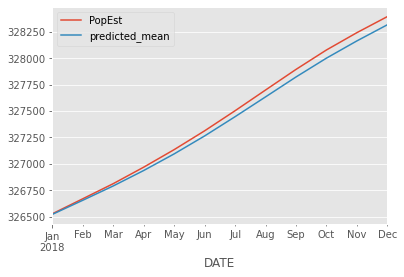

In [148]:
test["PopEst"].plot(legend="real")
df_predict["predicted_mean"].plot(legend="Preddcion")
plt.show()

## ARCH

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

In [19]:
df=pd.read_csv('./Datos/Index2018.csv')

In [20]:
df.date=pd.to_datetime(df.date,dayfirst=True)

In [21]:
df.isnull().sum()

date      0
spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

In [22]:
df.set_index('date',inplace=True)
df=df.asfreq('b')

In [24]:
df.isnull().sum()

spx       8
dax       8
ftse      8
nikkei    8
dtype: int64

In [26]:
df=df.fillna(method="ffill")

In [27]:
df.isnull().sum()

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

In [28]:
# pip install arch

Note: you may need to restart the kernel to use updated packages.


In [29]:
from arch import arch_model

<AxesSubplot:xlabel='date'>

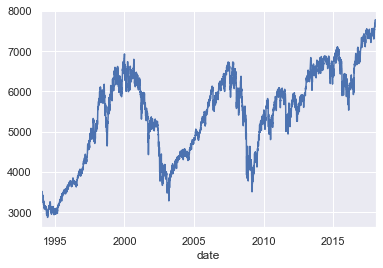

In [31]:
df['ftse'].plot()

In [33]:
df["TV_ftse"]=df['ftse'].pct_change(1)*100

<AxesSubplot:xlabel='date'>

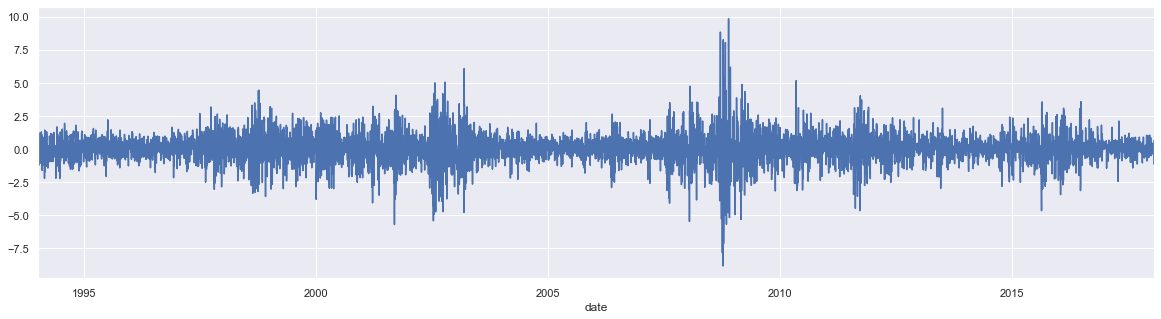

In [34]:
df["TV_ftse"].plot(figsize=(20,5))

In [37]:
df["Volatilidad"]=df['TV_ftse'].mul(df['TV_ftse'])

<AxesSubplot:xlabel='date'>

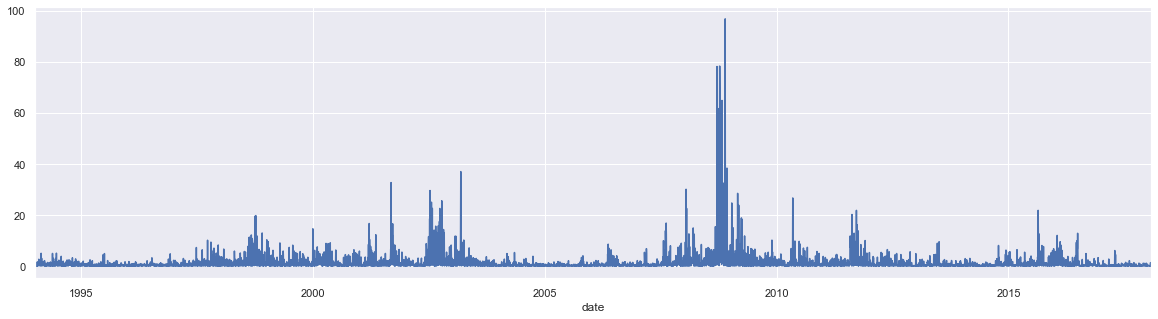

In [38]:
df["Volatilidad"].plot(figsize=(20,5))

In [39]:
## Arch
model_arch=arch_model(df.TV_ftse[1:])
result_arch=model_arch.fit()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 13095358228.925074
Iteration:      2,   Func. Count:     15,   Neg. LLF: 3316272663.839606
Iteration:      3,   Func. Count:     23,   Neg. LLF: 8471.10851526324
Iteration:      4,   Func. Count:     29,   Neg. LLF: 8478.252806125416
Iteration:      5,   Func. Count:     35,   Neg. LLF: 8418.145534541141
Iteration:      6,   Func. Count:     41,   Neg. LLF: 8503.158736023322
Iteration:      7,   Func. Count:     47,   Neg. LLF: 8418.153230157168
Iteration:      8,   Func. Count:     53,   Neg. LLF: 8417.890524627057
Iteration:      9,   Func. Count:     59,   Neg. LLF: 8410.647245530905
Iteration:     10,   Func. Count:     64,   Neg. LLF: 8410.646877975418
Iteration:     11,   Func. Count:     69,   Neg. LLF: 8410.646871498702
Iteration:     12,   Func. Count:     73,   Neg. LLF: 8410.646871496969
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8410.646871498702
            Iterations: 12
 

In [40]:
result_arch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                TV_ftse   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8410.65
Distribution:                  Normal   AIC:                           16829.3
Method:            Maximum Likelihood   BIC:                           16856.3
                                        No. Observations:                 6276
Date:                Mon, Mar 13 2023   Df Residuals:                     6275
Time:                        18:47:44   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0422  1.030e-02      4.103  4.081e-05 [2.206e-02,6.243e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0124  3.264e-03      3.810  1.391e-04 [6.037e-03,1.883e-02]
alpha[1]       0.0880  1.135e-02      7.749  9.242e-15   [6.571e-02,  0.110]
beta[1]        0.9018  1.279e-02     70.518      0.000     [  0.877,  0.927]
============================================================================

Covariance estimator: robust
"""

### ARCH 1

In [47]:
model_arch1=arch_model(df.TV_ftse[1:],mean="Constant",vol="ARCH",p=1)
result_arch=model_arch1.fit(update_freq=1)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 38476.766788342204
Iteration:      2,   Func. Count:     13,   Neg. LLF: 14503.543820834615
Iteration:      3,   Func. Count:     20,   Neg. LLF: 9420.535229295128
Iteration:      4,   Func. Count:     26,   Neg. LLF: 9236.603944302544
Iteration:      5,   Func. Count:     30,   Neg. LLF: 9236.603925076519
Iteration:      6,   Func. Count:     33,   Neg. LLF: 9236.603925076626
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9236.603925076519
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6


In [48]:
result_arch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                TV_ftse   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -9236.60
Distribution:                  Normal   AIC:                           18479.2
Method:            Maximum Likelihood   BIC:                           18499.4
                                        No. Observations:                 6276
Date:                Mon, Mar 13 2023   Df Residuals:                     6275
Time:                        18:58:26   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0350  1.366e-02      2.564  1.036e-02 [8.244e-03,6.178e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.8175  3.463e-02     23.607 3.268e-123 [  0.750,  0.885]
alpha[1]       0.3818  4.570e-02      8.355  6.529e-17 [  0.292,  0.471]
========================================================================

Covariance estimator: robust
"""

#### ARCH(2)

In [49]:
model_arch1=arch_model(df.TV_ftse[1:],mean="Constant",vol="ARCH",p=2)
result_arch=model_arch1.fit(update_freq=1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 43626.45592252472
Iteration:      2,   Func. Count:     16,   Neg. LLF: 11256.919975964955
Iteration:      3,   Func. Count:     24,   Neg. LLF: 9834.393267129246
Iteration:      4,   Func. Count:     31,   Neg. LLF: 9224.230526881416
Iteration:      5,   Func. Count:     38,   Neg. LLF: 8984.122453293794
Iteration:      6,   Func. Count:     43,   Neg. LLF: 8984.121962488998
Iteration:      7,   Func. Count:     47,   Neg. LLF: 8984.12196248922
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8984.121962488998
            Iterations: 7
            Function evaluations: 47
            Gradient evaluations: 7


In [50]:
result_arch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                TV_ftse   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -8984.12
Distribution:                  Normal   AIC:                           17976.2
Method:            Maximum Likelihood   BIC:                           18003.2
                                        No. Observations:                 6276
Date:                Mon, Mar 13 2023   Df Residuals:                     6275
Time:                        18:58:38   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0422  1.185e-02      3.565  3.638e-04 [1.902e-02,6.546e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6239  2.918e-02     21.377 2.193e-101 [  0.567,  0.681]
alpha[1]       0.2368  3.218e-02      7.358  1.865e-13 [  0.174,  0.300]
alpha[2]       0.2693  3.206e-02      8.401  4.426e-17 [  0.207,  0.332]
========================================================================

Covariance estimator: robust
"""

### GARCH

#### GARCH(1,1)

In [45]:
model_arch11=arch_model(df.TV_ftse[1:],mean="Constant",vol="GARCH",p=1,q=1)
result_arch=model_arch11.fit(update_freq=5)

Iteration:      5,   Func. Count:     35,   Neg. LLF: 8418.145534541141
Iteration:     10,   Func. Count:     64,   Neg. LLF: 8410.646877975418
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8410.646871498702
            Iterations: 12
            Function evaluations: 73
            Gradient evaluations: 12


In [46]:
result_arch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                TV_ftse   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8410.65
Distribution:                  Normal   AIC:                           16829.3
Method:            Maximum Likelihood   BIC:                           16856.3
                                        No. Observations:                 6276
Date:                Mon, Mar 13 2023   Df Residuals:                     6275
Time:                        18:57:18   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0422  1.030e-02      4.103  4.081e-05 [2.206e-02,6.243e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0124  3.264e-03      3.810  1.391e-04 [6.037e-03,1.883e-02]
alpha[1]       0.0880  1.135e-02      7.749  9.242e-15   [6.571e-02,  0.110]
beta[1]        0.9018  1.279e-02     70.518      0.000     [  0.877,  0.927]
============================================================================

Covariance estimator: robust
"""

In [51]:
model_arch11=arch_model(df.TV_ftse[1:],mean="Constant",vol="GARCH",p=1,q=2)
result_arch=model_arch11.fit(update_freq=5)

Iteration:      5,   Func. Count:     40,   Neg. LLF: 8420.601530652337
Iteration:     10,   Func. Count:     73,   Neg. LLF: 8410.652520595515
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8410.646871423822
            Iterations: 14
            Function evaluations: 96
            Gradient evaluations: 14


In [52]:
result_arch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                TV_ftse   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8410.65
Distribution:                  Normal   AIC:                           16831.3
Method:            Maximum Likelihood   BIC:                           16865.0
                                        No. Observations:                 6276
Date:                Mon, Mar 13 2023   Df Residuals:                     6275
Time:                        18:58:53   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0422  1.029e-02      4.107  4.012e-05 [2.209e-02,6.241e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0124  3.126e-03      3.977  6.967e-05 [6.307e-03,1.856e-02]
alpha[1]       0.0880  1.354e-02      6.498  8.153e-11   [6.142e-02,  0.114]
beta[1]        0.9018      0.202      4.458  8.256e-06     [  0.505,  1.298]
beta[2]        0.0000      0.193      0.000      1.000     [ -0.378,  0.378]
============================================================================

Covariance estimator: robust
"""

In [54]:
# pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [81]:
datos=pd.read_csv('./Datos/Index2018.csv')
datos.date=pd.to_datetime(datos.date,dayfirst=True)
datos.set_index('date',inplace=True)
datos=datos.asfreq('b')
datos=datos.fillna(method="ffill")


In [82]:
datos

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.900000,2224.95,3445.980000,18124.01
1994-01-10,475.270000,2225.00,3440.580000,18443.44
1994-01-11,474.130000,2228.10,3413.770000,18485.25
1994-01-12,474.170000,2182.06,3372.020000,18793.88
1994-01-13,472.470000,2142.37,3360.010000,18577.26
...,...,...,...,...
2018-01-23,2839.130362,13559.60,7731.827774,24124.15
2018-01-24,2837.544008,13414.74,7643.428966,23940.78
2018-01-25,2839.253031,13298.36,7615.839954,23669.49


## Division del dataset

In [83]:
tamanyo=int(len(datos)*0.8)
df_train,df_test=datos.iloc[:tamanyo],datos.iloc[tamanyo:]

## Ajustamos el modelo

In [84]:
from pmdarima.arima import auto_arima

In [85]:
modelo_auto=auto_arima(df_train["nikkei"])

In [87]:
modelo_auto

ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [88]:
modelo_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5021
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -33629.214
Date:                Mon, 13 Mar 2023   AIC                          67270.429
Time:                        19:14:52   BIC                          67309.556
Sample:                    01-07-1994   HQIC                         67284.139
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0730      0.084     -0.867      0.386      -0.238       0.092
ar.L2         -0.8466      0.066    -12.879      0.000      -0.975      -0.718
ma.L1          0.0238      0.085      0.281      0.779      -0.142       0.190
ma.L2          0.8167      0.070     11.606      0.000       0.679       0.955
ma.L3         -0.0451      0.013     -3.457      0.001      -0.071      -0.020
sigma2       3.84e+04    441.398     86.991      0.000    3.75e+04    3.93e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3610.40
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
resultado_auto=modelo_auto.fit(df_train["nikkei"])

In [109]:
df_pred=resultado_auto.predict(start="2013-04-08",end="2013-04-19")

In [110]:
df_pred

2013-04-08    12808.225116
2013-04-09    12808.335761
2013-04-10    12819.920592
2013-04-11    12818.981017
2013-04-12    12809.241435
2013-04-15    12810.748081
2013-04-16    12818.883993
2013-04-17    12817.014339
2013-04-18    12810.262665
2013-04-19    12812.338582
Freq: B, dtype: float64

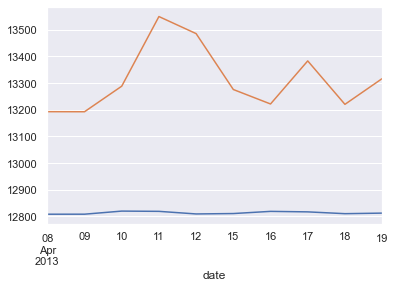

In [114]:
df_pred.plot()
df_test.loc["2013-04-08":"2013-04-19","nikkei"].plot()
plt.show()